In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral

from jax_cfd.spectral.time_stepping import crank_nicolson_rk4
from jax_cfd.spectral.equations import ForcedNavierStokes2D
from jax_cfd.base.initial_conditions import filtered_velocity_field

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [2]:
smooth = True

# physical parameters
viscosity = 1e-2
max_velocity = 7

# simulation parameters
final_time = 3.0
outer_steps = 20
inner_steps = 20
seed = 42

grid0 = grids.Grid((32, 32), domain=((0, 2*jnp.pi), (0, 2*jnp.pi)))
grid1 = grids.Grid((128, 128), domain=((0, 2*jnp.pi), (0, 2*jnp.pi)))
dt0 = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid0)
dt1 = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid1)

# step and trajectory functions
step_fn0 = crank_nicolson_rk4(ForcedNavierStokes2D(viscosity, grid0, smooth=smooth), dt0)
step_fn1 = crank_nicolson_rk4(ForcedNavierStokes2D(viscosity, grid1, smooth=smooth), dt1)

traj_fn0 = cfd.funcutils.trajectory(cfd.funcutils.repeated(step_fn0, inner_steps), outer_steps)
traj_fn1 = cfd.funcutils.trajectory(cfd.funcutils.repeated(step_fn1, inner_steps), outer_steps)

# initial velocity
v0 = filtered_velocity_field(random.PRNGKey(seed), grid0, max_velocity, 4)
v1 = filtered_velocity_field(random.PRNGKey(seed), grid1, max_velocity, 4)

vort0 = cfd.finite_differences.curl_2d(v0).data
# vort1 = cfd.finite_differences.curl_2d(v1).data
vort1 = jax.image.resize(vort0, (128, 128), 'nearest')
vort_hat0 = jnp.fft.rfftn(vort0)
vort_hat1 = jnp.fft.rfftn(vort1)

# compute trajectory
_, traj0 = traj_fn0(vort_hat0)
_, traj1 = traj_fn1(vort_hat1)
traj0 = jnp.fft.irfftn(traj0, axes=(1,2))
traj1 = jnp.fft.irfftn(traj1, axes=(1,2))

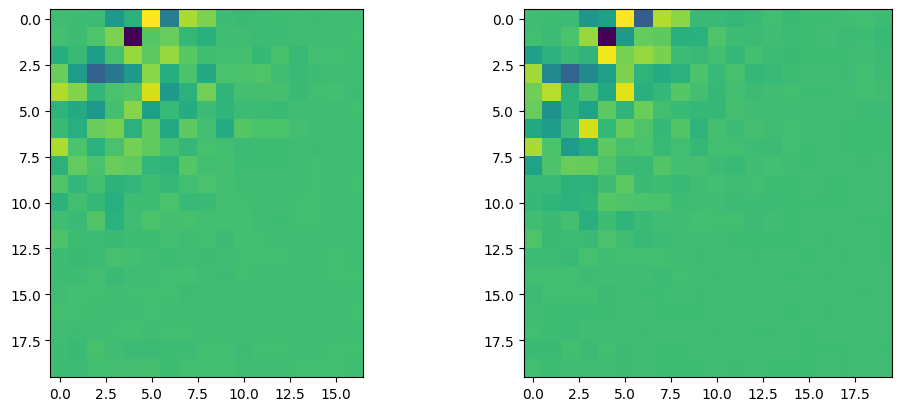

In [3]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(jnp.real(vort_hat0)[0:20,0:20])
ax[1].imshow(jnp.real(vort_hat1)[0:20,0:20])
plt.show()

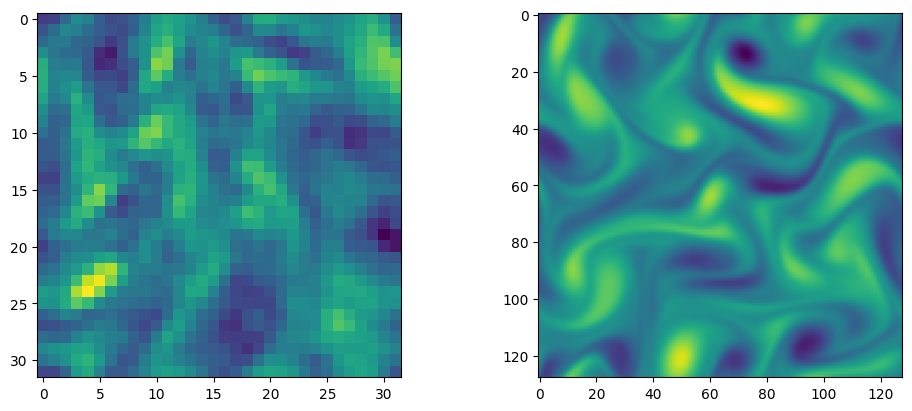

In [4]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(traj0[10])
ax[1].imshow(traj1[10])
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

ims = []
for i in range(0, 100):
    im = ax.imshow(traj[i], animated=True, cmap = 'viridis')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
HTML(ani.to_jshtml())

In [ ]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.conv = nnx.Conv(width, width, (1, 1), rngs=rngs)
        self.conv_out = nnx.Conv(width, width, (1, 1), rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.conv(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.conv_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.conv = nnx.Conv(in_dim, out_dim, (1, 1), rngs=rngs)

    def __call__(self, x):
        return self.conv(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        x = self.encode_layer(x)
        x = self.ano1(x)
        x = self.ano2(x)
        x = self.ano3(x)
        x = self.decode_layer(x)
        return x